# SA

1. list-based simulated annealing
    ###### 1. A list-based simulated annealing algorithm with crossover operator for the traveling salesman problem (doi.org/10.1007/s00521-021-06883-x) (2021)
    2. List-Based Simulated Annealing Algorithm for Traveling Salesman Problem, Zhan (doi.org/10.1155/2016/1712630) (2015)
    3. Enhanced List-Based Simulated Annealing Algorithm for Large-Scale Traveling Salesman Problem (doi.org/10.1109/ACCESS.2019.2945570)
    4. A hybrid genetic algorithm, list-based simulated annealing algorithm, and different heuristic algorithms for travelling salesman problem (doi.org/10.1093/jigpal/jzac028)
2. nested simulated annealing
    1. Nested Simulated Annealing Algorithm to Solve Large-Scale TSP Problem
3. tabu search simulated annealing
    ###### 1. Developing a dynamic neighborhood structure for an adaptive hybrid simulated annealing – tabu search algorithm to solve the symmetrical traveling salesman problem, Yu (doi.org/10.1016/j.asoc.2016.08.036)
    
###### 5. Traveling-Salesman-Problem Algorithm Based on Simulated Annealing and Gene-Expression Programming
###### 6. Solving the traveling salesman problem based on an adaptive simulated annealing algorithm with greedy search

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

## Data Loading

In [3]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

In [4]:
file_path = 'fi10639.tsp'

# 

In [5]:
# First City Index
FIRST_IDX = 0

## SA

In [73]:
# Global Variables
# SA
MAX_EVALUATION = 1000
SUB_ITERATIONS = 100
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

In [74]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

In [75]:
def two_opt_swap(path_map, path, iterations, coord_list, sa_start_time):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [ ]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE
    
    sa_start_time = time.time()

    for i in range(MAX_EVALUATION):
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list, sa_start_time)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            

    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

    return best_path, best_cost

In [ ]:
# Initialization ###############
initialize = initialize_greedy
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = sa(path_map, path, coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

## Improved SA

In [78]:
# Global Variables
# SA
MAX_EVALUATION = 1000
SUB_ITERATIONS = 100
TEMPERATURE = 100
COOLING_RATIO_1 = 0.5
COOLING_RATIO_2 = 0.9
COOLING_RATIO_THRESHOLD = 50
HEATING_RATIO = 1.1
TEMP_LIMIT = 1

In [79]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    # redefine first city index to random select
    first_idx = np.random.randint(cnt_cities, size=1)[0]
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

In [80]:
def two_opt_swap(path_map, path, iterations, coord_list, sa_start_time):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    # argsort cost array
    cost_idx_sort = np.argsort(cost_arr)
    
    # initialize temperature
    temperature = TEMPERATURE
    
    # for 10% of the longest distance cities in the path
    for c in range(cnt_cities//10):
        
        # check timeout
        if time.time()-sa_start_time>53:
            break
            
        # save best cost
        temp_cost = best_cost.copy()
        
        # check all cities with 2-opt transformation
        for i in range(cnt_cities):
            
            # check timeout
            if time.time()-sa_start_time>53:
                break
            
            curr_path = best_path.copy()
            # Select two indices of flip points, one with the c'th longest distance in path
            sel_idx = np.sort(np.array([cost_idx_sort[-1-c], i]))
            sel_idx[0]+=1
            if sel_idx[0]==sel_idx[1]:
                continue

            # Path Flip and update cost array
            curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
            curr_cost_arr = path_cost(path_map, curr_path)

            # Compare to the best path
            curr_cost = curr_cost_arr.sum()
            if curr_cost < best_cost:
                best_path = curr_path
                best_cost = curr_cost
        
        # if cost has reduced, break loop
        if best_cost < temp_cost:
            break
        # if the c'th longest distance in the path didn't reduced, heat temperature and continue loop
        else:
            temperature = temperature * HEATING_RATIO
    
    while temperature > TEMP_LIMIT:

        # check timeout
        if time.time()-sa_start_time>53:
            break
            
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        
        # if temperature lower than the threshold, apply another cooling ratio
        if temperature < COOLING_RATIO_THRESHOLD:
            temperature = temperature * COOLING_RATIO_2
        else:
            temperature = temperature * COOLING_RATIO_1
    return best_path, best_cost

In [81]:
def sa(path_map, path, coord_list):
    sa_start_time = time.time()
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE
    
    # set max evaluation number to number of cities
    MAX_EVALUATION = path_map.shape[0]

    for i in range(MAX_EVALUATION):
        
        # check timeout
        if time.time()-sa_start_time>53:
            break
            
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list, sa_start_time)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost

    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

    return best_path, best_cost

/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_9695/1914097468.py:74: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


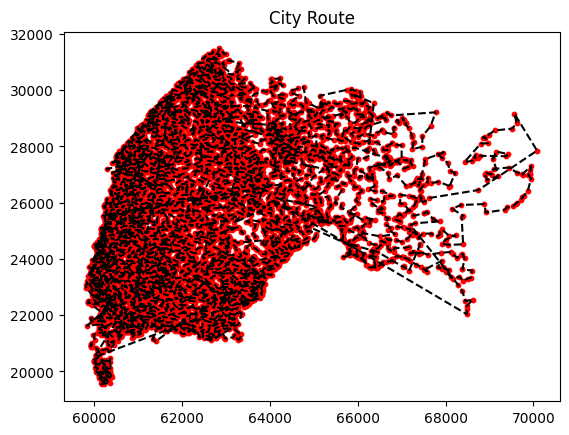

Execution Time: 59.117263078689575
Path: [2265, 2266, 2219, 2298, 2299, 2348, 2399, 2453, 2454, 2455, 2498, 2545, 2591, 2590, 2544, 2497, 2398, 2347, 2349, 2350, 2267, 2268, 2300, 2301, 2456, 2457, 2499, 2592, 2679, 2546, 2400, 2351, 2145, 2144, 2143, 2087, 2020, 1943, 1942, 1941, 1894, 1853, 1940, 2019, 2142, 2221, 2220, 2053, 2086, 2141, 2052, 1974, 1936, 1892, 1937, 1938, 1893, 1939, 1816, 1763, 1815, 1814, 1723, 1724, 1722, 1721, 1678, 1587, 1492, 1442, 1493, 1538, 1588, 1443, 1402, 1238, 1200, 1157, 1199, 1109, 931, 776, 738, 683, 682, 615, 549, 423, 681, 930, 1066, 1065, 1064, 929, 979, 1020, 1234, 1235, 1284, 1236, 1156, 1324, 1537, 1720, 1627, 1490, 1491, 1441, 1585, 1586, 1677, 1762, 1813, 1973, 2018, 2085, 2139, 2218, 2174, 2140, 2175, 2264, 2297, 2263, 2346, 2345, 2396, 2451, 2452, 2397, 2496, 2543, 2542, 2589, 2634, 2676, 2728, 2824, 2872, 2990, 2774, 2727, 2675, 2633, 2540, 2494, 2493, 2492, 2539, 2491, 2449, 2394, 2395, 2341, 2342, 2296, 2343, 2344, 2450, 2495, 2541, 2921

In [82]:
# Initialization ###############
initialize = initialize_greedy
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = sa(path_map, path, coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))